In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [2]:
def split_into_rgb_channels(image):
    """Split the target image into its red, green and blue channels.image - a numpy array of shape (rows, columns, 3).
    output - three numpy arrays of shape (rows, columns) and dtype same as
    image, containing the corresponding channels.
    """
    red = image[:,:,2]
    green = image[:,:,1]
    blue = image[:,:,0]
    return red, green, blue

In [3]:
def rotate_bound(image, angle,cX,cY):
    # grab the dimensions of the image
    (h, w) = image.shape[:2] 
    # grab the rotation matrix, then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
 
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
 
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
 
    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


In [4]:
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(maxContour)
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err

In [5]:
def get_mag_ang(img):

    """
    Gets image gradient (magnitude) and orientation (angle)

    Args:
        img

    Returns:
        Gradient, orientation
    """

    img = np.sqrt(img)

    gx = cv2.Sobel(np.float32(img), cv2.CV_32F, 1, 0)
    gy = cv2.Sobel(np.float32(img), cv2.CV_32F, 0, 1)

    mag, ang = cv2.cartToPolar(gx, gy)

    return mag, ang, gx, gy 

In [6]:
j=0
symmetry_dict=dict()
blue_dict=dict()
green_dict=dict()
red_dict=dict()
border_dict=dict()

In [7]:
#path='E:/ISIC DATA'
#path='E:/Desktop/smaller group'
path='E:/Desktop/ppp'
trainingpath='E:/Training'

import pickle
name="isic_data"
df=pickle.load(open(name,"rb"))

import cv2

filelist=os.listdir(path)
meta=[file for file in filelist if not file.endswith(".jpeg") and not file.endswith(".png") and file.startswith("ISIC")]
pics=[file for file in filelist if (file.endswith(".jpeg") or file.endswith(".png")) and file.startswith("ISIC")]


In [8]:
j=0
for i in range(j,len(pics)):

    imgname=pics[i]
    filename=path+'/'+pics[i]
    
    label=imgname.split('.')[0]

    orig_img=cv2.imread(filename, cv2.IMREAD_COLOR)
    img=orig_img

    #normalize image

    norm_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

    img=norm_image

    #split image into RGB channels



    r,g,b=split_into_rgb_channels(img)
   # print(filename)
    #plt.subplot(2,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
    #plt.subplot(2,2,2),plt.imshow(b),plt.xticks([]),plt.yticks([]),plt.title('blue')
    #plt.subplot(2,2,3),plt.imshow(g),plt.xticks([]),plt.yticks([]),plt.title('green')
    #plt.subplot(2,2,4),plt.imshow(r),plt.xticks([]),plt.yticks([]),plt.title('red')

    #reduce noise

    # Do some denoising on blue channel because that usually gives best contrast
    gaussian = cv2.GaussianBlur(b,(3,3),0)

    colorgaussian=cv2.GaussianBlur(img,(3,3),0)
    #plt.imshow(colorgaussian)

    #plt.subplot(1,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
    #plt.subplot(1,2,2),plt.imshow(gaussian),plt.xticks([]),plt.yticks([]),plt.title('gaussian')

    #find edge & image segmentation

    ## TRY DEEP LEARNING TOOL FOR THIS

    import cv2
    import numpy as np
    #fig,ax =plt.subplots(figsize = (10,10))
    #R,G,B=split_into_rgb_channels(img)


    kernel = np.ones((5,5),np.uint8)
    #gray = cv2.cvtColor(gaussian, cv2.COLOR_RGB2GRAY)
    th, threshed = cv2.threshold(gaussian, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    erosion = cv2.erode(threshed,kernel,iterations = 3)
    dilation = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
    #plt.subplot(2,2,1),plt.imshow(erosion),plt.xticks([]),plt.yticks([]),plt.title('erosion')
    #plt.subplot(2,2,2),plt.imshow(dilation),plt.xticks([]),plt.yticks([]),plt.title('dilation')
    ## Find the first contour that greate than 100, locate in centeral region
    ## Adjust the parameter when necessary
    cnts, hierarchy=cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
    cnts = sorted(cnts, key=cv2.contourArea)
    H,W = img.shape[:2]
    maxContour = 0


    for contour in cnts:
        cv2.drawContours(img,contour,-1,(255,0,0),-1)
        contourSize = cv2.contourArea(contour)
        if contourSize > maxContour:
            maxContour = contourSize
            maxContourData = contour
        #if contour
    cv2.drawContours(img,[contour],-1,(255,0,0),-1)
    ## Create mask and do bitwise-op
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, [contour],-1, 255, -1)
    #area = cv2.contourArea(contour)
    dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
    #plt.subplot(2,2,3),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
    #plt.subplot(2,2,4),plt.imshow(dst),plt.xticks([]),plt.yticks([]),plt.title('only roi')

    for contour in cnts:
        cv2.drawContours(img,contour,-1,(255,0,0),-1)
        contourSize = cv2.contourArea(contour)
        if contourSize > maxContour:
            maxContour = contourSize
            maxContourData = contour
        #if contour
    cv2.drawContours(img,[contour],-1,(255,0,0),-1)
    ## Create mask and do bitwise-op
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, [contour],-1, 255, -1)
    #area = cv2.contourArea(contour)
    dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
    
    fourcorners=[(0,0),(img.shape[:2][1]-1,0),(0,img.shape[:2][0]-1),(img.shape[:2][1]-1,img.shape[:2][0]-1)]

    orig_cnts=cnts
    new_cnts=list()
    for con in range(len(cnts)):
        contour=cnts[con]
        bunch=[tuple(contour[num][0]) for num in range(len(contour))]
        y_min=min(bunch, key=lambda t: t[0])[0]
        y_max=max(bunch, key=lambda t: t[0])[0]
        x_min=min(bunch, key=lambda t: t[1])[1]
        x_max=max(bunch, key=lambda t: t[1])[1]

        y_count=0
        x_count=0

        for num in bunch:
            if num[0]==x_min:
                x_count=x_count+1
            if num[0]==x_max:
                x_count=x_count+1
            if num[1]==y_min:
                y_count=y_count+1
            if num[1]==y_max:
                y_count=y_count+1
        if (x_count>round(img.shape[:2][0]*0.6)) or (y_count>round(img.shape[:2][1]*0.6)):
            #new_cnts.append(cnts[con])
            cnts.pop(con)

    #retread to check if there are removed contour
    for contour in cnts:
        cv2.drawContours(img,contour,-1,(255,0,0),-1)
        contourSize = cv2.contourArea(contour)
        if contourSize > maxContour:
            maxContour = contourSize
            maxContourData = contour
        #if contour
    cv2.drawContours(img,[contour],-1,(255,0,0),-1)
    ## Create mask and do bitwise-op
    mask = np.zeros(img.shape[:2],np.uint8)
    cv2.drawContours(mask, [contour],-1, 255, -1)
    #area = cv2.contourArea(contour)
    dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
    #plt.subplot(1,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
    #plt.subplot(1,1,1),plt.imshow(dst),plt.xticks([]),
    #plt.yticks([]),plt.title('only roi %s' %pics[i])
   
    #Check for symmetry: bigger value more malignant

    # get angle and center for rotation
    (a,b),(MA,ma),angle = cv2.fitEllipse(maxContourData)
    #print(a,b,MA,ma,angle)
    a=int(a)
    b=int(b)


    rotated_roi=rotate_bound(dst,angle,a,b)

    #plt.imshow(rotated_roi)
    #plt.colorbar()



    from mpl_toolkits.axes_grid1 import AxesGrid

    imageO=rotated_roi
    imageLR=np.fliplr(rotated_roi)
    imageUD=np.flipud(rotated_roi)
    #plt.subplot(1,2,1),plt.imshow((imageO.astype("float")-imageLR.astype("float"))**2),plt.title('LR symmetry'),plt.xticks([]),plt.yticks([])
    #plt.subplot(1,2,2),plt.imshow((imageO.astype("float")-imageUD.astype("float"))**2),plt.title('UD symmetry'),plt.xticks([]),plt.yticks([])

    lr=mse(rotated_roi, np.fliplr(rotated_roi))
    ud=mse(rotated_roi, np.flipud(rotated_roi))

    #print((lr+ud)/2)

    symmetry_dict[label]=(lr+ud)/2

    #Check Color: bigger value more malignant

    colorcheck = cv2.bitwise_and(orig_img, orig_img, mask=mask)
    #plt.imshow(colorcheck)

    color = ('b','g','r')
    #fig=plt.figure()
    zerovalues=list()
    #ax=fig.add_subplot(2,1,1)
    b_list=[]
    g_list=[]
    r_list=[]
    for i,col in enumerate(color):
        histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
        #ax.plot(histr,color = col)
        zerovalues.append(histr[0])
        histr=histr[1:]
        #plt.xlim([0,255])
        #ax.set_yscale('log')
        if col=='b':
            blue_dict[label]=histr.std()
        if col=='g':
            green_dict[label]=histr.std()
        if col=='r':
            red_dict[label]=histr.std()
        #print(histr.std())
    #plt.show()
    #zerovalues
    #print(type(std_list))
    #print(std_list)

    #Check border



    h=20; w=20
    tots_gradient=[]
    for point in maxContourData[:,0]:
        x=point[0]
        y=point[1]
        #print(x,y)
        y1=y-h; y2=y+h
        x1=x-w; x2=x+w
        if y1<0:
            y1=0
        if y2>H:
            y2=H
        if x1<0:
            x1=0
        if x2>W:
            x2=W
        #print(x1,y1,x2,y2)
        crop_img = orig_img[:,:,0][y1:y2, x1:x2].copy()
        mag,ang,gx,gy=get_mag_ang(crop_img)
        tots_gradient.append(mag.mean())

    border_dict[label]=np.mean(tots_gradient)
    j=j+1


#print(symmetry_dict,color_dict,border_dict)

'ISIC_0010690'

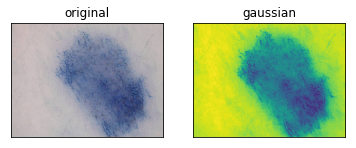

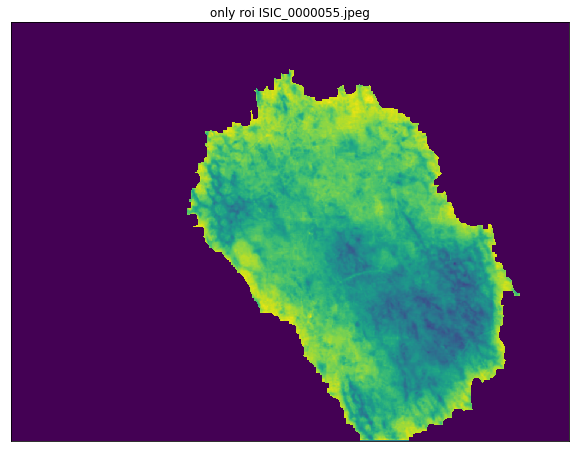

In [13]:
i=50
imgname=pics[i]
filename=path+'/'+pics[i]

orig_img=cv2.imread(filename, cv2.IMREAD_COLOR)
img=orig_img

#normalize image

norm_image = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

img=norm_image

#split image into RGB channels



r,g,b=split_into_rgb_channels(img)
# print(filename)
plt.subplot(2,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(2,2,2),plt.imshow(b),plt.xticks([]),plt.yticks([]),plt.title('blue')
plt.subplot(2,2,3),plt.imshow(g),plt.xticks([]),plt.yticks([]),plt.title('green')
plt.subplot(2,2,4),plt.imshow(r),plt.xticks([]),plt.yticks([]),plt.title('red')

#reduce noise

# Do some denoising on blue channel because that usually gives best contrast
gaussian = cv2.GaussianBlur(b,(3,3),0)

colorgaussian=cv2.GaussianBlur(img,(3,3),0)
plt.imshow(colorgaussian)

plt.subplot(1,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(1,2,2),plt.imshow(gaussian),plt.xticks([]),plt.yticks([]),plt.title('gaussian')

#find edge & image segmentation

## TRY DEEP LEARNING TOOL FOR THIS

import cv2
import numpy as np
fig,ax =plt.subplots(figsize = (10,10))
R,G,B=split_into_rgb_channels(img)


kernel = np.ones((5,5),np.uint8)
#gray = cv2.cvtColor(gaussian, cv2.COLOR_RGB2GRAY)
th, threshed = cv2.threshold(gaussian, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
erosion = cv2.erode(threshed,kernel,iterations = 3)
dilation = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel)
plt.subplot(2,2,1),plt.imshow(erosion),plt.xticks([]),plt.yticks([]),plt.title('erosion')
plt.subplot(2,2,2),plt.imshow(dilation),plt.xticks([]),plt.yticks([]),plt.title('dilation')
## Find the first contour that greate than 100, locate in centeral region
## Adjust the parameter when necessary
cnts, hierarchy=cv2.findContours(erosion,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE )
cnts = sorted(cnts, key=cv2.contourArea)
H,W = img.shape[:2]
maxContour = 0


for contour in cnts:
    cv2.drawContours(img,contour,-1,(255,0,0),-1)
    contourSize = cv2.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
    #if contour
cv2.drawContours(img,[contour],-1,(255,0,0),-1)
## Create mask and do bitwise-op
mask = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(mask, [contour],-1, 255, -1)
#area = cv2.contourArea(contour)
dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
plt.subplot(2,2,3),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(2,2,4),plt.imshow(dst),plt.xticks([]),plt.yticks([]),plt.title('only roi')

for contour in cnts:
    cv2.drawContours(img,contour,-1,(255,0,0),-1)
    contourSize = cv2.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
    #if contour
cv2.drawContours(img,[contour],-1,(255,0,0),-1)
## Create mask and do bitwise-op
mask = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(mask, [contour],-1, 255, -1)
#area = cv2.contourArea(contour)
dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)

fourcorners=[(0,0),(img.shape[:2][1]-1,0),(0,img.shape[:2][0]-1),(img.shape[:2][1]-1,img.shape[:2][0]-1)]

orig_cnts=cnts
new_cnts=list()
for con in range(len(cnts)):
    contour=cnts[con]
    bunch=[tuple(contour[num][0]) for num in range(len(contour))]
    y_min=min(bunch, key=lambda t: t[0])[0]
    y_max=max(bunch, key=lambda t: t[0])[0]
    x_min=min(bunch, key=lambda t: t[1])[1]
    x_max=max(bunch, key=lambda t: t[1])[1]

    y_count=0
    x_count=0

    for num in bunch:
        if num[0]==x_min:
            x_count=x_count+1
        if num[0]==x_max:
            x_count=x_count+1
        if num[1]==y_min:
            y_count=y_count+1
        if num[1]==y_max:
            y_count=y_count+1
    if (x_count>round(img.shape[:2][0]*0.6)) or (y_count>round(img.shape[:2][1]*0.6)):
        #new_cnts.append(cnts[con])
        cnts.pop(con)

#retread to check if there are removed contour
for contour in cnts:
    cv2.drawContours(img,contour,-1,(255,0,0),-1)
    contourSize = cv2.contourArea(contour)
    if contourSize > maxContour:
        maxContour = contourSize
        maxContourData = contour
    #if contour
cv2.drawContours(img,[contour],-1,(255,0,0),-1)
## Create mask and do bitwise-op
mask = np.zeros(img.shape[:2],np.uint8)
cv2.drawContours(mask, [contour],-1, 255, -1)
#area = cv2.contourArea(contour)
dst = cv2.bitwise_and(gaussian, gaussian, mask=mask)
plt.subplot(1,2,1),plt.imshow(img),plt.xticks([]),plt.yticks([]),plt.title('original')
plt.subplot(1,1,1),plt.imshow(dst),plt.xticks([]),
plt.yticks([]),plt.title('only roi %s' %pics[i])

#Check for symmetry: bigger value more malignant

# get angle and center for rotation
(a,b),(MA,ma),angle = cv2.fitEllipse(maxContourData)
#print(a,b,MA,ma,angle)
a=int(a)
b=int(b)


rotated_roi=rotate_bound(dst,angle,a,b)

#plt.imshow(rotated_roi)
#plt.colorbar()



from mpl_toolkits.axes_grid1 import AxesGrid

imageO=rotated_roi
imageLR=np.fliplr(rotated_roi)
imageUD=np.flipud(rotated_roi)
#plt.subplot(1,2,1),plt.imshow((imageO.astype("float")-imageLR.astype("float"))**2),plt.title('LR symmetry'),plt.xticks([]),plt.yticks([])
#plt.subplot(1,2,2),plt.imshow((imageO.astype("float")-imageUD.astype("float"))**2),plt.title('UD symmetry'),plt.xticks([]),plt.yticks([])

lr=mse(rotated_roi, np.fliplr(rotated_roi))
ud=mse(rotated_roi, np.flipud(rotated_roi))

#print((lr+ud)/2)


In [ ]:

#Check Color: bigger value more malignant

colorcheck = cv2.bitwise_and(orig_img, orig_img, mask=mask)
plt.imshow(colorcheck)

color = ('b','g','r')
fig=plt.figure()
zerovalues=list()
ax=fig.add_subplot(2,2,1)
std_list=[]
for i,col in enumerate(color):
    histr = cv2.calcHist([colorcheck],[i],None,[256],[0,256])
    ax.plot(histr,color = col)
    zerovalues.append(histr[0])
    histr=histr[1:]
    plt.xlim([0,255])
    ax.set_yscale('log')
    std_list.append([histr.std(),col])
    #print(histr.std())
plt.show()
#zerovalues
#print(type(std_list))
#print(std_list)


#Check border



h=20; w=20
tots_gradient=[]
for point in maxContourData[:,0]:
    x=point[0]
    y=point[1]
    #print(x,y)
    y1=y-h; y2=y+h
    x1=x-w; x2=x+w
    if y1<0:
        y1=0
    if y2>H:
        y2=H
    if x1<0:
        x1=0
    if x2>W:
        x2=W
    #print(x1,y1,x2,y2)
    crop_img = orig_img[:,:,0][y1:y2, x1:x2].copy()
    mag,ang,gx,gy=get_mag_ang(crop_img)
    tots_gradient.append(mag.mean())

    border_dict[imgname]=np.mean(tots_gradient)

In [ ]:
plt.imshow(dst)

In [9]:
with open('sym_data.pickle', 'wb') as f:
    pickle.dump(symmetry_dict, f)
with open('b_data.pickle', 'wb') as f:
    pickle.dump(blue_dict, f)
with open('g_data.pickle', 'wb') as f:
    pickle.dump(green_dict, f)
with open('r_data.pickle', 'wb') as f:
    pickle.dump(red_dict, f)
with open('bor_data.pickle', 'wb') as f:
    pickle.dump(border_dict, f)

In [30]:
for i in range(len(pics)):
    old_name='E:/ISIC DATA'+'/%s'%(pics[i].split('.')[0])
    new_name=path+'/%s'%(pics[i].split('.')[0])
    shutil.copy(old_name, new_name)

In [32]:
import json
from pandas.io.json import json_normalize
import pandas as pd
for file in meta:
    filename=path+'/'+file
    f=open(filename,"rt")
    data=json.load(f)
    if "df" not in locals():
        df=json_normalize(data)
    else:
        df1=json_normalize(data)
        df=df.append(df1,ignore_index=True)

C:\Users\shshi\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
